# **Curso Python: Clase 21**
## Factor analysis

# Spearman's Correlation Matrix

In [1]:
# Read in the data from the csv file
import pandas as pd
CO2Data = pd.read_csv("../folder_datos/Terminos_lagoon_TA_DIC_2023_RawData.csv")

##  Bartlett's test and KMO test for factor analysis suitability.

In [2]:
def perform_adequacy_tests(data, selected_columns):
    """
    Perform Bartlett's test and KMO test for factor analysis.

    Parameters:
        data (pd.DataFrame): The input dataset.
        selected_columns (list): List of column names to include in the analysis.

    Returns:
        dict: Results of Bartlett's test and KMO test.
    """
    from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

    # Select numeric data and drop missing values
    numeric_values = data[selected_columns].dropna().select_dtypes(include=['float64', 'int64']).values

    # Perform Bartlett's test
    chi_square, p_value = calculate_bartlett_sphericity(numeric_values)
    print(f"Bartlett's Test: p-value = {p_value:.4f}, chi-square = {chi_square:.4f}")

    # Perform KMO test
    _, kmo_model = calculate_kmo(numeric_values)
    print(f"KMO Value: {kmo_model:.1f}")

   # 📝 Print interpretation of KMO value
    if kmo_model > 0.8:
        print("✅ Suitability: Excellent 🌟")
    elif 0.7 <= kmo_model <= 0.79:
        print("✅ Suitability: Acceptable 👍")
    elif 0.6 <= kmo_model <= 0.69:
        print("⚠️ Suitability: Mediocre 🤔")
    else:
        print("❌ Suitability: Poor 🚫")

    print("ℹ️ Interpretation: A KMO value above 0.6 is considered acceptable for factor analysis.")

    # 🔄 Return results
    return {"bartlett": {"chi_square": chi_square, "p_value": p_value}, "kmo": kmo_model}


In [3]:
# Select the variables for analysis
# Note: Ensure that the column names match those in your dataset
selected_vars = ['depth_m', 'do_mg_l', 'sal_psu', 
                 'turbidity_fnu', 'temp_c', 'ta_micromol_kg', 'dic_micromol_kg', 'chlorophy_microg_l']

# Perform the adequacy tests
results = perform_adequacy_tests(CO2Data, selected_vars)

Bartlett's Test: p-value = 0.0000, chi-square = 317.8409
KMO Value: 0.5
❌ Suitability: Poor 🚫
ℹ️ Interpretation: A KMO value above 0.6 is considered acceptable for factor analysis.


## Choosing the Number of Factors

In [4]:
def perform_eigenvalues_and_plot(data, selected_columns):
    """
    Perform PCA, extract eigenvalues, apply the Kaiser criterion, and plot a scree plot.

    Parameters:
        data (pd.DataFrame): The input dataset.
        selected_columns (list): List of column names to include in the analysis.

    Returns:
        int: Number of factors to retain based on the Kaiser criterion.
    """
    import numpy as np
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    # 🧹 Select numeric data and drop missing values
    numeric_values = data[selected_columns].dropna().select_dtypes(include=['float64', 'int64']).values

    # 🧪 Perform PCA
    pca = PCA()
    pca.fit(numeric_values)

    # 📊 Extract eigenvalues
    eigenvalues = pca.explained_variance_
    print("📈 Eigenvalues:")
    for i, eigenvalue in enumerate(eigenvalues, start=1):
        print(f"   - Component {i}: {eigenvalue:.4f}")

    # 📝 Apply the Kaiser criterion
    n_factors = np.sum(eigenvalues > 1)
    print(f"\n🔍 Number of factors to retain (Kaiser criterion): {n_factors} {'✅ Suitable' if n_factors > 0 else '❌ Not Suitable'}")

    # 📉 Plot scree plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
    plt.axhline(y=1, color='red', linestyle='--', label='Kaiser Criterion')
    plt.title('Scree Plot')
    plt.xlabel('Factor Number')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.show()

    return n_factors

📈 Eigenvalues:
   - Component 1: 445594.9685
   - Component 2: 85940.1935
   - Component 3: 26154.0519
   - Component 4: 199.4444
   - Component 5: 80.9233
   - Component 6: 4.8196
   - Component 7: 2.7831
   - Component 8: 0.6037

🔍 Number of factors to retain (Kaiser criterion): 7 ✅ Suitable


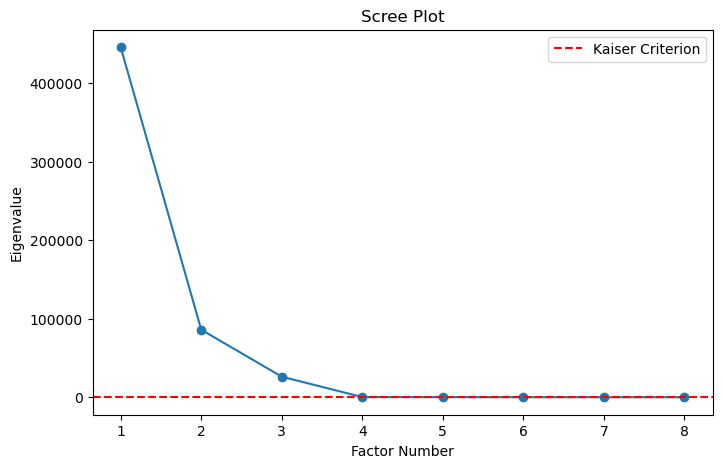

np.int64(7)

In [5]:
perform_eigenvalues_and_plot(CO2Data, selected_vars)

## Factor Loadings  

In [6]:
def get_factor_loadings(data, selected_columns, n_factors=None, rotation='varimax'):
    """
    Perform factor analysis and return the factor loadings matrix.
    
    Parameters:
        data (pd.DataFrame): The input dataset.
        selected_columns (list): List of column names to include in the analysis.
        n_factors (int): Number of factors to extract. If None, will use Kaiser criterion.
        rotation (str): Rotation method ('varimax', 'promax', 'oblimin', etc.)
        
    Returns:
        pd.DataFrame: Factor loadings matrix with variables as rows and factors as columns.
    """
    from factor_analyzer import FactorAnalyzer
    import pandas as pd
    import numpy as np
    
    # Select numeric data and drop missing values
    numeric_data = data[selected_columns].dropna().select_dtypes(include=['float64', 'int64'])
    
    # If n_factors not specified, use Kaiser criterion
    if n_factors is None:
        pca = PCA()
        pca.fit(numeric_data)
        eigenvalues = pca.explained_variance_
        n_factors = np.sum(eigenvalues > 1)
        print(f"Using Kaiser criterion: retaining {n_factors} factors")
    
    # Perform factor analysis
    fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation)
    fa.fit(numeric_data)
    
    # Get factor loadings
    loadings = fa.loadings_
    
    # Create a DataFrame for better visualization
    loadings_df = pd.DataFrame(loadings, 
                              index=selected_columns,
                              columns=[f'Factor {i+1}' for i in range(n_factors)])
    
    # Print formatted loadings
    print("\nFACTOR LOADINGS MATRIX:")
    print(loadings_df.round(3))
    
    # Print interpretation guidelines
    print("\nINTERPRETATION GUIDELINES:")
    print("- Loadings > |0.3| are generally considered meaningful")
    print("- Loadings > |0.4| are considered important")
    print("- Loadings > |0.5| are considered very significant")
    print("- Variables with highest loadings on each factor define its meaning")
    
    return loadings_df

In [7]:
loadings = get_factor_loadings(CO2Data, selected_vars, n_factors=2)


FACTOR LOADINGS MATRIX:
                    Factor 1  Factor 2
depth_m               -0.086     0.355
do_mg_l                0.138    -0.087
sal_psu               -0.428     0.499
turbidity_fnu          0.018     0.470
temp_c                 0.112    -0.591
ta_micromol_kg         0.881     0.073
dic_micromol_kg        1.001    -0.149
chlorophy_microg_l    -0.047     0.327

INTERPRETATION GUIDELINES:
- Loadings > |0.3| are generally considered meaningful
- Loadings > |0.4| are considered important
- Loadings > |0.5| are considered very significant
- Variables with highest loadings on each factor define its meaning


c:\Users\Omar\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
import matplotlib
from matplotlib.patheffects import withStroke

def plot_fa_biplot(df, variables, group_col=None, label_col=None,
                         n_factors=2, title='Factor Analysis Biplot',
                         show_labels=True, save_path=None, figsize=(10, 10)):


    # Select numeric data and drop missing values
    numeric_values = df[variables].dropna().select_dtypes(include=['float64', 'int64']).values

    # Prepare data
    X = df[variables].dropna()
    df_filtered = df.loc[X.index]
    X_scaled = StandardScaler().fit_transform(X)

    # Factor analysis
    fa = FactorAnalysis(n_components=n_factors)
    factor_scores = fa.fit_transform(X_scaled)
    loadings = fa.components_.T * np.sqrt(fa.noise_variance_)[:, np.newaxis]

    # Group and label info
    groups = df_filtered[group_col].values if group_col else None
    labels = df_filtered[label_col].values if label_col else ["" for _ in range(len(factor_scores))]
    unique_groups = np.unique(groups) if groups is not None else None
    cmap = matplotlib.colormaps.get_cmap('viridis').resampled(len(unique_groups)) if groups is not None else None

    # Initialize plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.axhline(0, color='lightgray', lw=1)
    ax.axvline(0, color='lightgray', lw=1)
    ax.add_artist(plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='dashed'))

    # Plot variable loadings
    arrow_scale = 4
    for i, var in enumerate(variables):
        x, y = loadings[i] * arrow_scale
        ax.arrow(0, 0, x, y, color='black', linewidth=2.4,
                 alpha=0.9, head_width=0.12, head_length=0.15, zorder=3, length_includes_head=True)
        ax.text(x * 1.2, y * 1.2, var, fontsize=13, weight='bold',
                ha='center', va='center',
                path_effects=[withStroke(linewidth=3, foreground='white')], zorder=4)

    # Plot scores
    if groups is not None:
        for i, group in enumerate(unique_groups):
            idx = groups == group
            ax.scatter(factor_scores[idx, 0], factor_scores[idx, 1],
                       label=group, s=70, alpha=0.85,
                       edgecolor='white', linewidth=0.6, color=cmap(i), zorder=2)
            if show_labels:
                for j in np.where(idx)[0]:
                    ax.text(factor_scores[j, 0], factor_scores[j, 1], labels[j],
                            fontsize=6.5, alpha=0.5)
    else:
        ax.scatter(factor_scores[:, 0], factor_scores[:, 1], alpha=0.7, s=50, zorder=2)

    # Formatting
    ax.set_xlabel('Factor 1', fontsize=14, weight='bold', family='serif')
    ax.set_ylabel('Factor 2', fontsize=14, weight='bold', family='serif')
    ax.set_title(title, fontsize=16, weight='bold', family='serif')
    if groups is not None:
        ax.legend(title=group_col, fontsize=10, title_fontsize=11)
    ax.tick_params(labelsize=11)
    ax.set_aspect('equal')

    # Auto-limits
    margin = 0.5
    ax.set_xlim(factor_scores[:, 0].min() - margin, factor_scores[:, 0].max() + margin)
    ax.set_ylim(factor_scores[:, 1].min() - margin, factor_scores[:, 1].max() + margin)

    plt.tight_layout()

    # Save figure
    if save_path:
        dpi = 600 if save_path.endswith(('.png', '.jpg')) else None
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    plt.show()



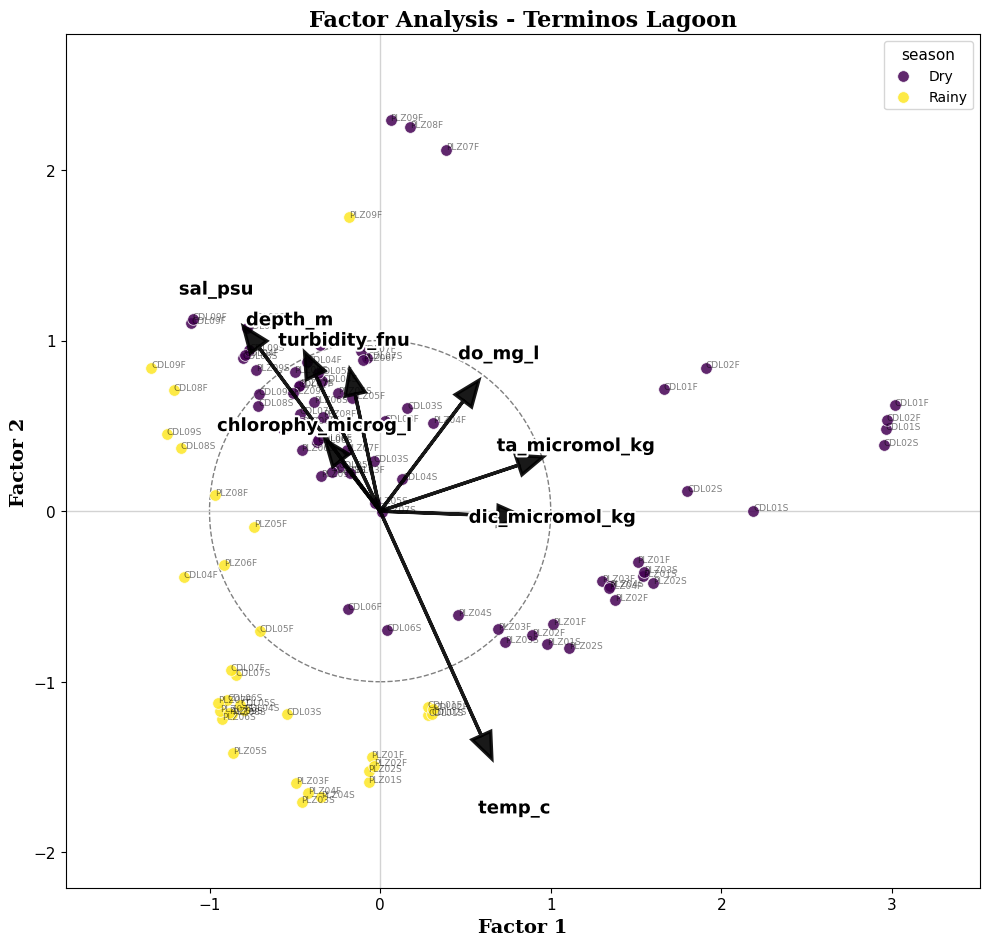

In [9]:
plot_fa_biplot(
    df=CO2Data,
    variables=selected_vars,
    group_col='season',
    label_col='sample',
    n_factors=2,
    title='Factor Analysis - Terminos Lagoon'
)



In [10]:
def plot_fa_biplot_3d(df, variables, group_col=None, label_col=None,
                      n_factors=3, title='3D Factor Analysis Biplot',
                      show_labels=False, save_path=None, elev=30, azim=120):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np
    from sklearn.decomposition import FactorAnalysis
    from sklearn.preprocessing import StandardScaler
    import matplotlib

    # Prepare data
    X = df[variables].dropna()
    df_filtered = df.loc[X.index]
    X_scaled = StandardScaler().fit_transform(X)

    # Factor analysis
    fa = FactorAnalysis(n_components=n_factors)
    factor_scores = fa.fit_transform(X_scaled)

    # Group and label info
    groups = df_filtered[group_col].values if group_col else None
    labels = df_filtered[label_col].values if label_col else ["" for _ in range(len(factor_scores))]
    unique_groups = np.unique(groups) if groups is not None else None
    cmap = matplotlib.colormaps.get_cmap('viridis').resampled(len(unique_groups)) if groups is not None else None

    # 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)

    # Scatter plot by group
    if groups is not None:
        for i, group in enumerate(unique_groups):
            idx = groups == group
            ax.scatter(factor_scores[idx, 0], factor_scores[idx, 1], factor_scores[idx, 2],
                       label=group, color=cmap(i), s=50, edgecolor='white', alpha=0.8)
            if show_labels:
                for j in np.where(idx)[0]:
                    ax.text(factor_scores[j, 0], factor_scores[j, 1], factor_scores[j, 2],
                            labels[j], fontsize=6, alpha=0.5)
    else:
        ax.scatter(factor_scores[:, 0], factor_scores[:, 1], factor_scores[:, 2],
                   s=50, alpha=0.8)

    # Axes labels and title
    ax.set_xlabel('Factor 1', fontsize=12)
    ax.set_ylabel('Factor 2', fontsize=12)
    ax.set_zlabel('Factor 3', fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')
    if groups is not None:
        ax.legend(title=group_col)

    plt.tight_layout()

    # Save plot if needed
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()


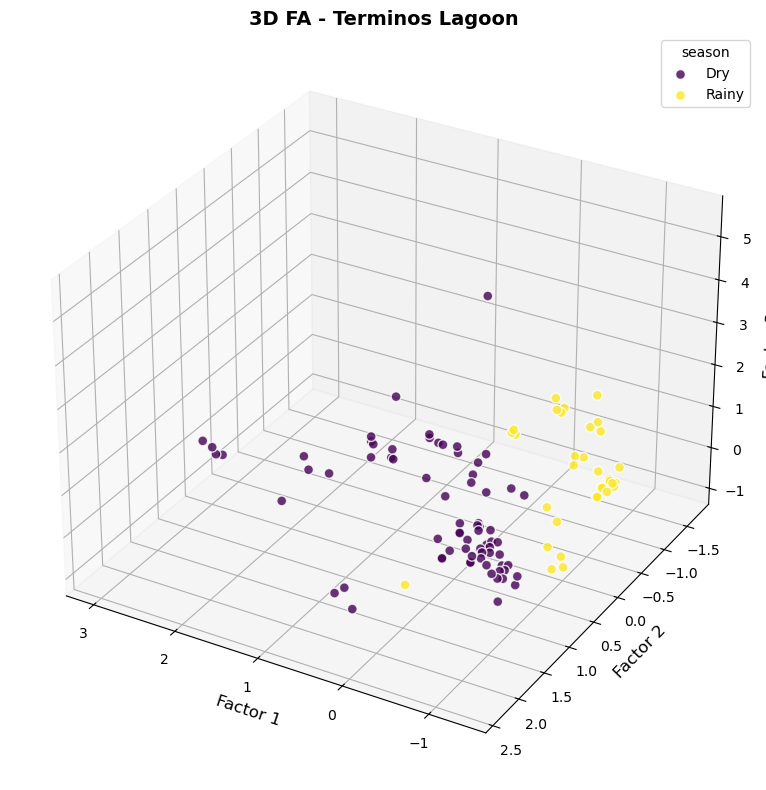

In [11]:
plot_fa_biplot_3d(
    df=CO2Data,
    variables=selected_vars,
    group_col='season',
    label_col='sample',
    n_factors=3,
    title='3D FA - Terminos Lagoon',
    show_labels=False
)



In [12]:
def plot_fa_biplot_3d_plotly(df, variables, group_col=None, label_col=None,
                             n_factors=3, title='3D FA Interactive Biplot'):
    import pandas as pd
    import numpy as np
    import plotly.express as px
    from sklearn.decomposition import FactorAnalysis
    from sklearn.preprocessing import StandardScaler

    # Prepare data
    X = df[variables].dropna()
    df_filtered = df.loc[X.index].copy()
    X_scaled = StandardScaler().fit_transform(X)

    # FA
    fa = FactorAnalysis(n_components=n_factors)
    scores = fa.fit_transform(X_scaled)

    # Add scores to DataFrame
    for i in range(n_factors):
        df_filtered[f'Factor {i+1}'] = scores[:, i]

    # Default labels
    if label_col is None:
        df_filtered['label'] = df_filtered.index.astype(str)
    else:
        df_filtered['label'] = df_filtered[label_col].astype(str)

    # Build interactive 3D scatter plot
    fig = px.scatter_3d(
        df_filtered,
        x='Factor 1', y='Factor 2', z='Factor 3',
        color=group_col,
        hover_name='label',
        title=title,
        opacity=0.8,
        width=900,
        height=700
    )

    fig.update_traces(marker=dict(size=6, line=dict(width=0.5, color='DarkSlateGrey')))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
    fig.show()


In [13]:
plot_fa_biplot_3d_plotly(
    df=CO2Data,
    variables=selected_vars,
    group_col='season',
    label_col='sample',
    n_factors=3,
    title='3D FA - Terminos Lagoon',
)